In [79]:
from hmc.state.ising_state import IsingState
from hmc.monte_carlo.ising_hmc import IsingHMC
from hmc.integrator.leap_frog import LeapFrogIntegrator
from hmc.integrator.leap_frog_autograd import LeapFrogIntegratorAutoGrad
import numpy as np 
import torch
from matplotlib import pyplot as plt

# Ising Model Setting

We are considering the 2D Ising model. The length of grid $ L = 6$, so the number of sites is $6^{2} = 36$.
External field $h=0$, spin interaction coupling $J=1$

In [80]:
dim = 2 # dimension of Ising model
L = 6 # length of grid
J = 1 # spin-spin interaction coupling
h = 0  # External field

beta = 0.5 # temporary beta for tuning

# Autograd

We used two method to calculate the gradient of Hamiltonian with respect to $\psi$ and momentum $p$. One is to manually find the analytical form of gradient of Hamiltonian with respect to $\psi$ and momentum $p$. The other method is to using PyTorch autograd to calculate gradient value.

In the first method, we find 
$$\frac{\partial \mathcal{H}}{\partial \mathbf{p}}=\mathbf{p}$$
$$\frac{\partial \mathcal{H}}{\partial \mathbf{\psi}} = J^{\prime} \mathbf{K}^{\prime} [\mathbf{\psi} - \tanh{ (J^{\prime} \mathbf{K^{\prime}\psi+h^{\prime} })} ] $$

We want to verify two methods can produce the same gradient value.

In [81]:
step_size = 0.1
trajectory_length = 1
n_steps = int(trajectory_length/step_size)

leap_frog = LeapFrogIntegratorAutoGrad(step_size, n_steps)
state = IsingState(length=6,dim=2,beta=beta)

# calculate theoretical gradient
psi = np.random.randn(state.n_sites)
mom = np.random.randn(state.n_sites)
grad_U_theory = state.get_gradU(psi)
grad_K_theory = mom

# calculate gradient with torch autograd
psi = torch.tensor(psi,requires_grad=True)
mom = torch.tensor(mom,requires_grad=True)
grad_U_autograd = leap_frog.get_grad(hamiltonian_func=state.get_hamiltonian_torch, pos=psi, mom=mom)
grad_U_autograd = psi.grad.data.numpy()
grad_K_autograd = mom.grad.data.numpy()


grad_U_diff = np.max(np.abs(grad_U_theory - grad_U_autograd))
grad_K_diff = np.max(np.abs(grad_K_theory - grad_K_autograd))

print(f"Difference of gradient of potential energy: {grad_U_diff}")
print(f"Difference of gradient of kinetic energy: {grad_K_diff}")


Difference of gradient of potential energy: 8.881784197001252e-16
Difference of gradient of kinetic energy: 0.0


# Mass $M$

In Hamiltonian Monte Carlo, the momentums are virtue and are randomly generated from a Gaussian distribution. In many tutorials, the standard Gaussian $\mathbf{N}(0,1)$ is used, and according to the "detailed balance", the corresponding kinetic energy is defined as $K = \mathbf{p^{\top} p }/2$.  If we further consider the "mass", $K = \mathbf{p^{\top}M^{-1} p }/2$, where $\mathbf{M}$ is the mass matrix, then $\mathbf{p}$ should be generated in $\mathbf{N}(\mathbf{0},\mathbf{M})$.

For the Hamiltonian evolution can be ergodic, the kinetic energy should be large enough ($\sigma_{K} \approx \sigma_{V}$). The larger the kinetic energy, the more likely HMC algorithm explores region with small probability. 

The choosing of mass seems to rely on the estimation of $\sigma_{V}$. We simply use the default $M=1$ for now. 

# Step size and Trajectory Length

Step size $\epsilon$ and Trajectory length $L = \epsilon n_{steps}$ are two essential parameters in HMC.

Too large a stepsize $\epsilon$ will result in low acceptance rate for states proposed by simulating trajectories. Too small a stepsize will waste computation time. 

Too large trajectory length $L$ will make the state go too far from the concentration of probability, especially when the momentum $p$ is large. Too small $L$ will limit its ability to explore, and will lead to high autocorrelation.
 
## Acceptance Rate
Here, we will use acceptance rate to find a proper combination of $\epsilon$ and $n_{steps}$. Acceptance rates between 65% and 90% are good target values.

In [82]:
def get_acceptance_rate(step_size, n_steps, n_propose = 1000):
    state = IsingState(length=L,dim=dim,beta=beta,J=J,h=h)
    leap_frog = LeapFrogIntegrator(step_size, n_steps)
    mc = IsingHMC(ising_state=state,integrator=leap_frog)
    psi = state.get_state_vector()
    psi = mc.thermalize(psi)
    count = 0
    for _ in range(n_propose):
        new_psi= mc.update(psi)
        if np.array_equal(new_psi,psi) == False:
            count += 1
    acc_rate = count/n_propose
    return acc_rate


In [11]:

trajectory_length_array = 0.1*np.power(10, np.arange(3))
step_size_array = 0.01*np.power(10, np.arange(4))

acc_rate_array = []
for length in trajectory_length_array:
    result_array = []
    for step_size in step_size_array:
        n_steps = int(length/step_size)
        acc_rate = get_acceptance_rate(step_size, n_steps, n_propose = 1000)
        result_array.append(acc_rate)
        print(f"step size: {step_size}, trajectory length: {length}, acc rate: {acc_rate}")
    acc_rate_array.append(result_array)
acc_rate_array = np.array(acc_rate_array)

step size: 0.01, trajectory length: 0.1, acc rate: 1.0
step size: 0.1, trajectory length: 0.1, acc rate: 0.998
step size: 1.0, trajectory length: 0.1, acc rate: 0.0
step size: 10.0, trajectory length: 0.1, acc rate: 0.0
step size: 0.01, trajectory length: 1.0, acc rate: 1.0
step size: 0.1, trajectory length: 1.0, acc rate: 1.0
step size: 1.0, trajectory length: 1.0, acc rate: 0.08
step size: 10.0, trajectory length: 1.0, acc rate: 0.0
step size: 0.01, trajectory length: 10.0, acc rate: 1.0
step size: 0.1, trajectory length: 10.0, acc rate: 0.995
step size: 1.0, trajectory length: 10.0, acc rate: 0.001
step size: 10.0, trajectory length: 10.0, acc rate: 0.0


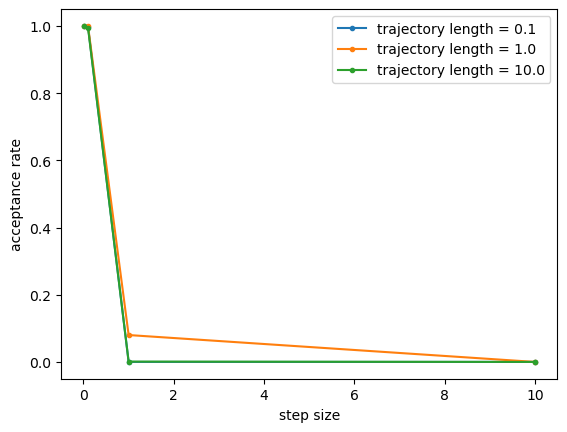

In [12]:
fig, ax = plt.subplots()

for i in range(trajectory_length_array.size):
    trajectory_length = trajectory_length_array[i]
    ax.plot(step_size_array, acc_rate_array[i], marker=".", label=f"trajectory length = {trajectory_length}")
ax.set_xlabel("step size")
ax.set_ylabel("acceptance rate")
ax.legend()

From the acceptance rates, the proper step size $\epsilon$ should lie in $(0.1, 1)$. But the proper trajectory length $L$ is to be determined. Even when $L>10$, the acceptance rate is still large enough.

What if we change value of $\beta$? We are interested in $\beta \in (0.1,0.7)$ 

It seems the step size $\epsilon=0.1$ and $L=10$ is a good combination. So we try it here.

In [91]:
step_size = 0.1
trajectory_length = 1
n_steps = int(trajectory_length/step_size)

beta_list = np.linspace(0.1,0.7,6*2+1)
acc_rate_list = []
for beta in beta_list:
    acc_rate = get_acceptance_rate(step_size, n_steps, n_propose = 1000)
    acc_rate_list.append(acc_rate)
    # print(f"beta: {beta},  acceptance rate: {acc_rate}")
acc_rate_list = np.array(acc_rate_list)

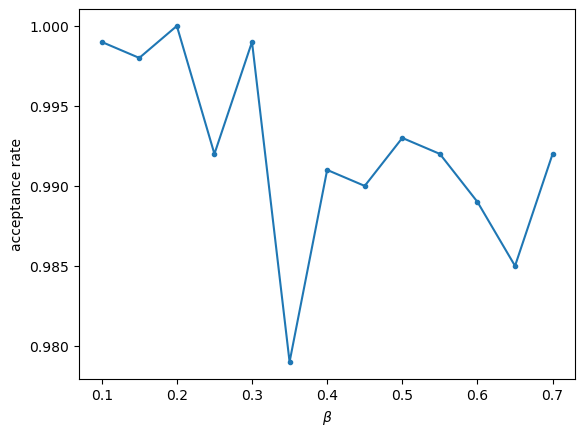

In [92]:
fig, ax = plt.subplots()
ax.plot(beta_list, acc_rate_list, marker=".")
ax.set_xlabel(r"$\beta$")
ax.set_ylabel("acceptance rate")
fig.show()

The acceptance rate is a little too high. But it works fine in practice.

## Autocorrelation

Since acceptance rate cannot give a good criterion for finding suitable trajectory length $L$, we now turn to autocorrelation. We'll use average magnetization $m = \frac{1}{N}\sum_{i=1}^{N} s_{i}$ as an observable to explore autocorrelation.

In [77]:
step_size = 0.4
trajectory_length_list = [1,10]
beta_list = [0.1, 0.4, 0.7]



result = []
for beta in beta_list:
    beta_result = []
    for L in trajectory_length_list:
        n_steps = int(L/step_size)
        leap_frog = LeapFrogIntegrator(step_size, n_steps)
        state = IsingState(length=L,dim=dim,beta=beta,J=J,h=h)
        mc = IsingHMC(ising_state=state,integrator=leap_frog)
        measurements = {"m": state.get_magnetization}
        measured_result = mc.sample(measurements=measurements,n_samples=1000,n_iters_per_sample=1, n_thermalization_iters=0)
        beta_result.append(measured_result["m"])
    result.append(beta_result)

result = np.array(result)

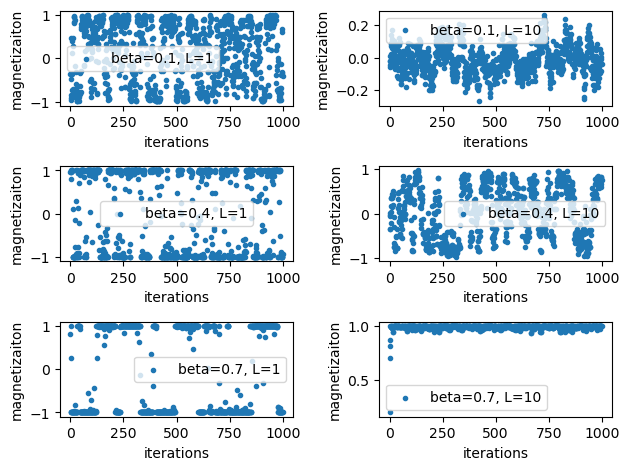

In [78]:

fig, ax = plt.subplots(len(beta_list), len(trajectory_length_list))
for i in range(len(beta_list)):
    for j in range(len(trajectory_length_list)):
        beta = beta_list[i]
        L = trajectory_length_list[j]
        ax[i,j].scatter(np.arange(result[i,j].size), result[i,j] ,marker=".", label = f"beta={beta}, L={L}")
        ax[i,j].set_xlabel("iterations")
        ax[i,j].set_ylabel("magnetizaiton")
        ax[i,j].legend()
fig.tight_layout()

The $L=1$ seems less autocorrelated than $L=10$. Also, in case of $L=1$, the state can hop from one ground state $m=1$ to another $m=-1$, while in case of $L=10$, the state is trapped into one of the ground state $m=1$.